In [1]:
### https://ml-challenge.mercadolibre.com/

import pandas as pd
import numpy as np
import gc
import xgboost as xgb 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def reduce_mem(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    _ = gc.collect()
    return df

In [2]:
!nvidia-smi

Sat Sep 25 19:50:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   45C    P0    39W / 300W |     47MiB / 32508MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   

# Load

In [3]:
train = pd.read_parquet('train.parquet')
train = reduce_mem(train)
gc.collect()
print(train.shape)

valid = train.loc[train.date >'2021-03-01'].copy()
gc.collect()

train = train.loc[train.date <= '2021-03-01'].copy()
gc.collect()

train['dcount'] = train.groupby('sku')['date'].transform('cumcount')
train['dcount_max'] = train.groupby('sku')['date'].transform('count')
train['icount'] = train['dcount_max'] - train['dcount']-1
gc.collect()

valid['dcount'] = valid.groupby('sku')['date'].transform('cumcount')
valid['dcount_max'] = valid.groupby('sku')['date'].transform('count')
valid['icount'] = valid['dcount_max'] - valid['dcount']-1
gc.collect()

del train['target_stock']
del valid['target_stock']

train.shape, valid.shape

(37660279, 20)


((18091368, 22), (19568911, 22))

# Build local Validation

In [4]:
%%time
print(valid.shape)
valid['sum_sell'] = valid.groupby('sku')['sold_quantity'].transform('sum')
valid = valid.loc[(valid.dcount_max==30)&(valid.sum_sell>0)].copy()
print(valid.shape)
valid['cs_sell'] = valid.groupby('sku')['sold_quantity'].transform('cumsum')

dt = valid.loc[valid.sold_quantity>0].groupby('sku')['cs_sell'].apply(list).reset_index(name='sells')
np.random.seed(1)
dt['target_stock'] = dt['sells'].apply(lambda x: np.random.choice(x) )
del dt['sells']
dt

(19568911, 22)
(17303490, 23)
CPU times: user 29.1 s, sys: 1.69 s, total: 30.8 s
Wall time: 30.5 s


,sku,target_stock
0,0,11
1,1,15
2,3,1
3,4,2
4,5,12
...,...,...
576778,660911,11
576779,660912,3
576780,660913,2
576781,660914,3


In [5]:
#merge target_stock to train and validation
valid = valid.merge(dt[['sku', 'target_stock']], on='sku', how='left')
train = train.merge(dt[['sku', 'target_stock']], on='sku', how='left')

valid.target_stock.value_counts()

1        2244570
2        1863660
3        1601700
4        1378200
5        1181310
          ...   
1099          30
1098          30
1097          30
1095          30
30030         30
Name: target_stock, Length: 1344, dtype: int64

In [6]:
def metric( ytrue, ypred ):
    tmp = ypred.loc[:,range(30)].cumsum(1).values.copy()
    tmp[tmp>1] = 1
    tmp[tmp<0] = 0
    tmp /= tmp.max(1, keepdims=True)
    return np.sum( (ytrue.loc[:,range(30)].values - tmp)**2 ) / ytrue.shape[0]    


valid['target'] = 1 *(valid['cs_sell'] >= valid['target_stock'])
print('Binary target average:', valid['target'].mean() )

ytrue = valid.pivot(index='sku', columns='dcount', values='target').reset_index()
ytrue = ytrue.reset_index(drop=True)
vals = ytrue.loc[:,range(30)].mean(0).values
vals[1:] = vals[1:] - vals[:-1]

valid['ypred'] = 1/30
VAL = valid.pivot(index='sku', columns='dcount', values='ypred').reset_index()
VAL = VAL.reset_index(drop=True)
VAL = VAL.fillna(1/30)

print( 'Metric for Average Prediction:', metric( ytrue, VAL ) )

Binary target average: 0.5184950550438091
Metric for Average Prediction: 5.1984754231660775


# Build Features

In [7]:
%%time

train['sell_lag'] = train['sold_quantity'] * train['minutes_active']
train['sell_lag'] = train.groupby('sku')['sell_lag'].transform('cumsum')
train['sell_act'] = train.groupby('sku')['minutes_active'].transform('cumsum')
train['sell_true'] = train['sell_lag'] / (train['sell_act']+1)
train['sell_true'] = train['sell_true'] / train['target_stock']
train['sell_lag_1'] = train['sell_true'] + train.groupby('sku')['sell_true'].shift(1)
train['sell_lag_2'] = train['sell_lag_1'] + train.groupby('sku')['sell_true'].shift(2)
train['sell_lag_3'] = train['sell_lag_2'] + train.groupby('sku')['sell_true'].shift(3)
train['sell_lag_4'] = train['sell_lag_3'] + train.groupby('sku')['sell_true'].shift(4)
train['sell_lag_5'] = train['sell_lag_4'] + train.groupby('sku')['sell_true'].shift(5)
train['sell_lag_6'] = train['sell_lag_5'] + train.groupby('sku')['sell_true'].shift(6)
train['sell_lag_7'] = train['sell_lag_6'] + train.groupby('sku')['sell_true'].shift(7)
train['sell_lag_8'] = train['sell_lag_7'] + train.groupby('sku')['sell_true'].shift(8)


train['price_lag'] = train.groupby('sku')['current_price'].transform('cumsum')
train['price_lag'] = train['price_lag'] / (train['sell_act']+1)
train['price_lag_1'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(1))
train['price_lag_2'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(2)) / (train['current_price']+1e-3)
train['price_lag_3'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(3)) / (train['current_price']+1e-3)
train['price_lag_4'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(4)) / (train['current_price']+1e-3)
train['price_lag_5'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(5)) / (train['current_price']+1e-3)
train['price_lag_6'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(6)) / (train['current_price']+1e-3)
train['price_lag_7'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(7)) / (train['current_price']+1e-3)
train['price_lag_8'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(8)) / (train['current_price']+1e-3)

train['act_lag'] = train['sell_act'] / (train['dcount']+1)
train['act_lag_1'] = train.groupby('sku')['act_lag'].shift(1)
train['act_lag_2'] = train.groupby('sku')['act_lag'].shift(2)
train['act_lag_3'] = train.groupby('sku')['act_lag'].shift(3)
train['act_lag_4'] = train.groupby('sku')['act_lag'].shift(4)
train['act_lag_5'] = train.groupby('sku')['act_lag'].shift(5)
train['act_lag_6'] = train.groupby('sku')['act_lag'].shift(6)
train['act_lag_7'] = train.groupby('sku')['act_lag'].shift(7)
train['act_lag_8'] = train.groupby('sku')['act_lag'].shift(8)

train['shipping_logistic_type_lag_1'] = train.groupby('sku')['shipping_logistic_type'].shift(1)

train['sold_quantity_log'] = train['sold_quantity']
train['sum_sells_1'] = train.groupby(['item_domain_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_2'] = train.groupby(['item_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_3'] = train.groupby(['item_title_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_4'] = train.groupby(['product_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_5'] = train.groupby(['product_family_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_6'] = train.groupby(['currency','listing_type','shipping_logistic_type','shipping_payment','site_id','dcount'])['sold_quantity_log'].transform('sum')

train['sold_lag_1'] = train.groupby('sku')['sold_quantity'].shift(1)
train['sold_lag_2'] = train.groupby('sku')['sold_quantity'].shift(2)
train['sold_lag_3'] = train.groupby('sku')['sold_quantity'].shift(3)
train['sold_lag_4'] = train.groupby('sku')['sold_quantity'].shift(4)
train['sold_lag_5'] = train.groupby('sku')['sold_quantity'].shift(5)
train['sold_lag_6'] = train.groupby('sku')['sold_quantity'].shift(6)
train['sold_lag_7'] = train.groupby('sku')['sold_quantity'].shift(7)
train['sold_lag_8'] = train.groupby('sku')['sold_quantity'].shift(8)

# Probability of selling all stock in each day
train['sold_quantity_target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)

_ = gc.collect()

CPU times: user 34.1 s, sys: 7.29 s, total: 41.4 s
Wall time: 41.4 s


In [8]:
train = train.sort_values(['sku','date']).reset_index(drop=True)
_ = gc.collect()

<AxesSubplot:>

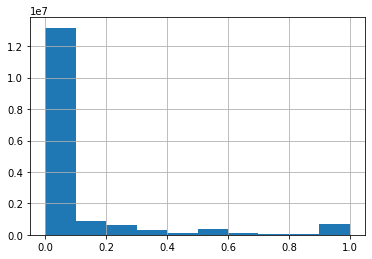

In [9]:
train['target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)

for i in range(30):
    train['target'+str(i)] = train.groupby('sku')['target'].shift(-(i+1))
train['target'].hist()

In [10]:
feats = ['target'+str(i) for i in range(28)]
train['nonull'] = 28-train[feats].isnull().sum(1)
train['target'] = train[feats].mean(1)
train['weight'] = train['nonull'] / 28
train['weight'] = train['weight'].fillna(0)
train['nonull'].value_counts()

0     2371785
1      574749
2      574405
3      573984
4      572906
5      571614
6      570292
7      569099
8      567932
9      567571
10     567130
11     566018
12     564732
13     563389
14     562240
15     561181
16     560861
17     560247
18     558775
19     557207
20     555727
21     554372
22     552978
23     552487
24     551599
25     550026
26     547804
27     546102
28     544156
Name: nonull, dtype: int64

In [11]:
features = [
    'sold_quantity',
    'current_price',
    'currency',
    'listing_type',
    'shipping_logistic_type',
    'shipping_payment',
    'minutes_active',
    'dow', 
    'item_domain_id',
    'item_id',
    'item_title_id', 'item_title_0', 'item_title_1',
    'site_id',
    'product_id',
    'product_family_id', 
    
    'target_stock',              
    'sell_lag', 'sell_act', 'sell_true',
    'sell_lag_1', 'sell_lag_2', 'sell_lag_3', 'sell_lag_4', 'sell_lag_5', 'sell_lag_6', 'sell_lag_7', 'sell_lag_8',    
    'price_lag', 
    'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7', 'price_lag_8',
    
    'act_lag',
    'act_lag_1', 'act_lag_2', 'act_lag_3', 'act_lag_4', 'act_lag_5', 'act_lag_6', 'act_lag_7', 'act_lag_8',
    
    'shipping_logistic_type_lag_1',

    'sold_quantity_log',
    'sum_sells_1', 'sum_sells_2', 'sum_sells_3', 'sum_sells_4', 'sum_sells_5', 'sum_sells_6',
    'sold_lag_1', 'sold_lag_2', 'sold_lag_3',  'sold_lag_4', 'sold_lag_5', 'sold_lag_6', 'sold_lag_7', 'sold_lag_8',
    
    'sold_quantity_target',
]

train[features].head()

,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,dow,item_domain_id,item_id,...,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_8,sold_quantity_target
0,0,172.789993,0,0,1,0,0.000000,0,46,83220,...,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,0,172.789993,0,0,1,0,0.000000,1,46,83220,...,51,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0,179.990005,0,0,1,0,872.650024,2,46,83220,...,84,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,0,179.990005,0,0,1,0,1440.000000,3,46,83220,...,161,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
4,0,179.990005,0,0,1,0,1440.000000,4,46,83220,...,104,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [12]:
train.icount.value_counts()

0     639351
1     638166
2     637768
3     637263
4     636062
5     634601
6     633111
7     631777
8     630470
9     630067
10    629555
11    628333
12    626922
13    625438
14    624165
15    622964
16    622608
17    621937
18    620325
19    618612
20    616976
21    615477
22    613950
23    613405
24    612461
25    610721
26    608270
27    606383
28    604230
Name: icount, dtype: int64

In [13]:
train[[
    'sku',
    'currency',
    'listing_type',
    'shipping_logistic_type',
    'shipping_payment',
    'item_domain_id',
    'item_id',
    'item_title_id', 'item_title_0', 'item_title_1',
    'site_id',
    'product_id',
    'product_family_id'
]].nunique()

sku                       639351
currency                       4
listing_type                   2
shipping_logistic_type         3
shipping_payment               2
item_domain_id              8383
item_id                   501318
item_title_id             464472
item_title_0              286162
item_title_1              409828
site_id                        3
product_id                 14823
product_family_id          28860
dtype: int64

In [14]:
train['fold'] = train['item_id'] % 5
train['fold'].value_counts()

4    3641734
2    3630232
1    3612277
3    3603819
0    3603306
Name: fold, dtype: int64

In [15]:
train = reduce_mem(train)
_ = gc.collect()

In [16]:
%%time

params = {
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.75,
    'colsample_bytree': 0.50,
    'min_child_weight': 1,
    'random_state': 2021,
    'objective': "reg:squarederror",
    'base_score': train.target.mean(),
    'tree_method': 'gpu_hist',
    'verbosity': 1,
    #'nthread': 16,
}

MODELS = []
NROUNDS = []
OOF = pd.DataFrame()
for fold in range(5):
    
    ind = (train.fold!=fold)&(train.target.notnull())&(train.sku.isin(valid.sku)) 
    print(fold, np.sum(ind))
    dtrain = xgb.DMatrix( train.loc[ind, features], weight=train.loc[ind,'weight'], label=train.loc[ind,'target'] ) ; gc.collect()
    
    ind = (train.fold==fold)&(train.target.notnull())&(train.sku.isin(valid.sku)) 
    print(fold, np.sum(ind))
    dvalid = xgb.DMatrix( train.loc[ind, features], weight=train.loc[ind,'weight'], label=train.loc[ind,'target'] ) ; gc.collect()

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=3000,#np.mean(NROUNDS),
        evals=[(dvalid,'valid')],
        early_stopping_rounds=33,
        verbose_eval=100,
        ) ; gc.collect()
    NROUNDS.append(model.best_iteration)
    MODELS.append(model)

0 12587031
0 3132552
[0]	valid-rmse:0.13925
[32]	valid-rmse:5515802623082496.00000
1 12586507
1 3133076
[0]	valid-rmse:0.15301
[33]	valid-rmse:966130076221440.00000
2 12561599
2 3157984
[0]	valid-rmse:0.14795
[33]	valid-rmse:268031359975424.00000
3 12586867
3 3132716
[0]	valid-rmse:0.13732
[33]	valid-rmse:475050796908544.00000
4 12556328
4 3163255
[0]	valid-rmse:0.13576
[33]	valid-rmse:9592612960862208.00000
CPU times: user 3min 28s, sys: 30.1 s, total: 3min 58s
Wall time: 1min 49s


In [17]:
ind = (train.icount==0)
tmp = train.loc[ind].copy()

dtest = xgb.DMatrix( tmp[features]) ; gc.collect()
tmp = tmp.reset_index(drop=True)

ypred = 1*MODELS[0].predict(dtest)
if len(MODELS)>1:
    for m in MODELS[1:]:
        ypred += m.predict(dtest)
    ypred /= len(MODELS)
    
tmp['ypred'] = np.clip(ypred,0,1)
tmp.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,target24,target25,target26,target27,target28,target29,nonull,weight,fold,ypred
0,0,2021-03-01,0,179.990005,0,0,1,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,1.0
1,1,2021-03-01,2,135.899994,0,1,0,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,1.0
2,3,2021-03-01,0,399.000000,1,1,0,0,0.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,1.0
3,4,2021-03-01,2,118.000000,0,1,0,0,243.278488,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,4,1.0
4,5,2021-03-01,1,579.630005,1,1,0,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.0


In [18]:
ind = (train.icount==0)
tmp = train.loc[ind].copy()

tmp['ypred'] = np.nan
for fold in range(5):
    dtest = xgb.DMatrix( tmp.loc[tmp.fold==fold,features]) ; gc.collect()
    tmp = tmp.reset_index(drop=True)
    tmp.loc[tmp.fold==fold, 'ypred'] = MODELS[fold].predict(dtest)
    
tmp['ypred'] = tmp['ypred'].clip(0,1)
tmp.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,month,...,target24,target25,target26,target27,target28,target29,nonull,weight,fold,ypred
0,0,2021-03-01,0,179.990005,0,0,1,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0,1.0
1,1,2021-03-01,2,135.899994,0,1,0,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.0
2,3,2021-03-01,0,399.000000,1,1,0,0,0.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.0
3,4,2021-03-01,2,118.000000,0,1,0,0,243.278488,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,4,1.0
4,5,2021-03-01,1,579.630005,1,1,0,0,1440.000000,3,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,3,0.0


In [19]:
dt1 = tmp.groupby('sku')['ypred'].agg('mean').reset_index()
dt1['ypred'] = dt1['ypred'].clip(0,1)
dt1

,sku,ypred
0,0,1.0
1,1,0.0
2,3,0.0
3,4,1.0
4,5,0.0
...,...,...
639346,660911,1.0
639347,660912,0.0
639348,660913,0.0
639349,660914,0.0


In [20]:
imp = pd.DataFrame().from_dict(MODELS[-1].get_fscore(), orient='index').sort_values(0, ascending=False).reset_index()
imp.head(40)

,index,0
0,act_lag,136
1,sum_sells_5,103
2,target_stock,95
3,price_lag_8,71
4,sum_sells_4,70
5,item_id,67
6,price_lag,60
7,item_title_1,57
8,dow,51
9,sum_sells_6,46


In [21]:
imp.tail(40)

,index,0
21,act_lag_3,28
22,item_title_0,28
23,shipping_logistic_type,26
24,sell_act,25
25,sell_lag_8,24
26,sell_lag_2,22
27,sum_sells_1,22
28,price_lag_2,20
29,price_lag_1,20
30,minutes_active,20


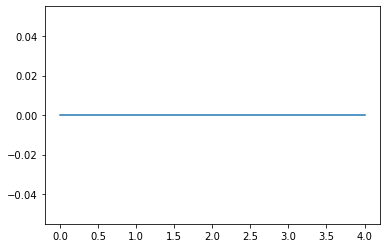

In [22]:
plt.plot(NROUNDS)

In [23]:
val = VAL.copy()
for i in range(1,30):
    val[i] = 1. / 30
val[29] = 1.

for i in range(7):
    val[i] = (1.00/(i+0.86))*val[['sku']].merge(dt1, on='sku', how='left')['ypred'].values
    val[i] = val[i].fillna(1/30)
    val[i] = val[i].clip(0,1)

for i in range(28,6,-1):
    val[i] = val[i].values*0.95 + val[i+1].values*0.05
for i in range(6,30):
    val[i] = val[i].values*0.95 + val[i-1].values*0.05
    
for i in range(1,30):
    val[i] = (val[i-1] + val[i] ).clip(0,1)
    
for i in range(28,7,-1):
    val[i] = val[i].values*0.60 + val[i+1].values*0.40
for i in range(7,30):
    val[i] = val[i].values*0.999 + val[i-1].values*0.001
    
for i in range(30):    
    val[i] = 0.999*val[i] + 0.001*(i*1./30)
    

for i in range(29,0,-1):
    val[i] = val[i] - val[i-1]
    val[i] = val[i].clip(0,1)

print( metric( ytrue, val ) )

9.587562597989532


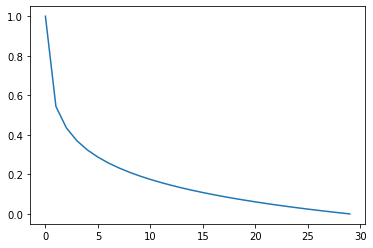

In [25]:
val = VAL.copy()
for i in range(1,30):
    val[i] = 1. / 30
val[29] = 1.


var = np.arange(0,30)
var = 1-np.log(15*var+1)
var -= var.min()
var /= var.max()
for i in range(9):
    val[i] = val[['sku']].merge(dt1, on='sku', how='left')['ypred'].values * var[i]
    val[i] = val[i].fillna(1/30)
    val[i] = val[i].clip(0,1)

for i in range(9,30):
    val[i] = val[i].values*0.95 + val[i-1].values*0.05
    
for i in range(1,30):
    val[i] = (val[i-1] + val[i] ).clip(0,1)

for i in range(28,9,-1):
    val[i] = val[i].values*0.55 + val[i+1].values*0.45
    
for i in range(29,0,-1):
    val[i] = val[i] - val[i-1]
    val[i] = val[i].clip(0,1)

print( metric( ytrue, val ) )

9.973666432548121


In [26]:
val.head(20)

dcount,sku,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033448,0.033587,0.033897,0.034587,0.036119,0.039524,0.04709,0.063904,0.101268,0.184298
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033448,0.033587,0.033897,0.034587,0.036119,0.039524,0.04709,0.063904,0.101268,0.184298
3,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033448,0.033587,0.033897,0.034587,0.036119,0.039524,0.04709,0.063904,0.101268,0.184298
5,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033448,0.033587,0.033897,0.034587,0.036119,0.039524,0.04709,0.063904,0.101268,0.184298
8,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033448,0.033587,0.033897,0.034587,0.036119,0.039524,0.04709,0.063904,0.101268,0.184298
9,11,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


<AxesSubplot:xlabel='dcount'>

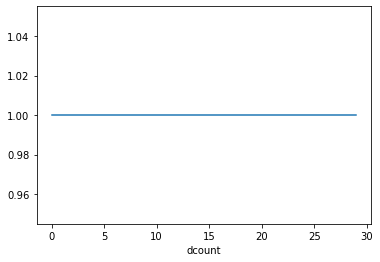

In [27]:
val.loc[3,range(30)].cumsum().plot()

<AxesSubplot:xlabel='dcount'>

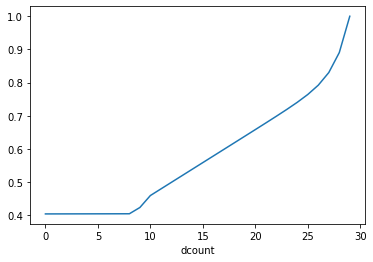

In [28]:
val.loc[:,range(30)].cumsum(1).mean().plot()

In [29]:
val.to_csv('validation-day-1-A.csv', index=False)

# Full train

In [30]:
train = pd.read_parquet('train.parquet')
train = reduce_mem(train)
gc.collect()
print(train.shape)

train['dcount'] = train.groupby('sku')['date'].transform('cumcount')
train['dcount_max'] = train.groupby('sku')['date'].transform('count')
train['icount'] = train['dcount_max'] - train['dcount']-1
gc.collect()

train.shape

(37660279, 20)


(37660279, 23)

In [31]:
test = pd.read_csv('../input/test_data.csv')
test.head()

,sku,target_stock
0,464801,3
1,645793,4
2,99516,8
3,538100,8
4,557191,10


In [32]:
%%time

train['sell_lag'] = train['sold_quantity'] * train['minutes_active']
train['sell_lag'] = train.groupby('sku')['sell_lag'].transform('cumsum')
train['sell_act'] = train.groupby('sku')['minutes_active'].transform('cumsum')
train['sell_true'] = train['sell_lag'] / (train['sell_act']+1)
train['sell_true'] = train['sell_true'] / train['target_stock']
train['sell_lag_1'] = train['sell_true'] + train.groupby('sku')['sell_true'].shift(1)
train['sell_lag_2'] = train['sell_lag_1'] + train.groupby('sku')['sell_true'].shift(2)
train['sell_lag_3'] = train['sell_lag_2'] + train.groupby('sku')['sell_true'].shift(3)
train['sell_lag_4'] = train['sell_lag_3'] + train.groupby('sku')['sell_true'].shift(4)
train['sell_lag_5'] = train['sell_lag_4'] + train.groupby('sku')['sell_true'].shift(5)
train['sell_lag_6'] = train['sell_lag_5'] + train.groupby('sku')['sell_true'].shift(6)
train['sell_lag_7'] = train['sell_lag_6'] + train.groupby('sku')['sell_true'].shift(7)
train['sell_lag_8'] = train['sell_lag_7'] + train.groupby('sku')['sell_true'].shift(8)


train['price_lag'] = train.groupby('sku')['current_price'].transform('cumsum')
train['price_lag'] = train['price_lag'] / (train['sell_act']+1)
train['price_lag_1'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(1))
train['price_lag_2'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(2)) / (train['current_price']+1e-3)
train['price_lag_3'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(3)) / (train['current_price']+1e-3)
train['price_lag_4'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(4)) / (train['current_price']+1e-3)
train['price_lag_5'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(5)) / (train['current_price']+1e-3)
train['price_lag_6'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(6)) / (train['current_price']+1e-3)
train['price_lag_7'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(7)) / (train['current_price']+1e-3)
train['price_lag_8'] = (train['current_price'] - train.groupby('sku')['price_lag'].shift(8)) / (train['current_price']+1e-3)

train['act_lag'] = train['sell_act'] / (train['dcount']+1)
train['act_lag_1'] = train.groupby('sku')['act_lag'].shift(1)
train['act_lag_2'] = train.groupby('sku')['act_lag'].shift(2)
train['act_lag_3'] = train.groupby('sku')['act_lag'].shift(3)
train['act_lag_4'] = train.groupby('sku')['act_lag'].shift(4)
train['act_lag_5'] = train.groupby('sku')['act_lag'].shift(5)
train['act_lag_6'] = train.groupby('sku')['act_lag'].shift(6)
train['act_lag_7'] = train.groupby('sku')['act_lag'].shift(7)
train['act_lag_8'] = train.groupby('sku')['act_lag'].shift(8)

train['shipping_logistic_type_lag_1'] = train.groupby('sku')['shipping_logistic_type'].shift(1)

train['sold_quantity_log'] = train['sold_quantity']
train['sum_sells_1'] = train.groupby(['item_domain_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_2'] = train.groupby(['item_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_3'] = train.groupby(['item_title_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_4'] = train.groupby(['product_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_5'] = train.groupby(['product_family_id','dcount'])['sold_quantity_log'].transform('sum')
train['sum_sells_6'] = train.groupby(['currency','listing_type','shipping_logistic_type','shipping_payment','site_id','dcount'])['sold_quantity_log'].transform('sum')

train['sold_lag_1'] = train.groupby('sku')['sold_quantity'].shift(1)
train['sold_lag_2'] = train.groupby('sku')['sold_quantity'].shift(2)
train['sold_lag_3'] = train.groupby('sku')['sold_quantity'].shift(3)
train['sold_lag_4'] = train.groupby('sku')['sold_quantity'].shift(4)
train['sold_lag_5'] = train.groupby('sku')['sold_quantity'].shift(5)
train['sold_lag_6'] = train.groupby('sku')['sold_quantity'].shift(6)
train['sold_lag_7'] = train.groupby('sku')['sold_quantity'].shift(7)
train['sold_lag_8'] = train.groupby('sku')['sold_quantity'].shift(8)

train['sold_quantity_target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)

_ = gc.collect()

CPU times: user 1min 9s, sys: 15.4 s, total: 1min 24s
Wall time: 1min 24s


In [33]:
features = [
    'sold_quantity',
    'current_price',
    'currency',
    'listing_type',
    'shipping_logistic_type',
    'shipping_payment',
    'minutes_active',
    'dow', 
    'item_domain_id',
    'item_id',
    'item_title_id', 'item_title_0', 'item_title_1',
    'site_id',
    'product_id',
    'product_family_id', 
    
    'target_stock',              
    'sell_lag', 'sell_act', 'sell_true',
    'sell_lag_1', 'sell_lag_2', 'sell_lag_3', 'sell_lag_4', 'sell_lag_5', 'sell_lag_6', 'sell_lag_7', 'sell_lag_8',    
    'price_lag', 
    'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7', 'price_lag_8',
    
    'act_lag',
    'act_lag_1', 'act_lag_2', 'act_lag_3', 'act_lag_4', 'act_lag_5', 'act_lag_6', 'act_lag_7', 'act_lag_8',
    
    'shipping_logistic_type_lag_1',

    'sold_quantity_log',
    'sum_sells_1', 'sum_sells_2', 'sum_sells_3', 'sum_sells_4', 'sum_sells_5', 'sum_sells_6',
    'sold_lag_1', 'sold_lag_2', 'sold_lag_3',  'sold_lag_4', 'sold_lag_5', 'sold_lag_6', 'sold_lag_7', 'sold_lag_8',
    
    'sold_quantity_target',
]

train[features].head()

,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active,dow,item_domain_id,item_id,...,sum_sells_6,sold_lag_1,sold_lag_2,sold_lag_3,sold_lag_4,sold_lag_5,sold_lag_6,sold_lag_7,sold_lag_8,sold_quantity_target
6094273,0,172.789993,0,0,1,0,0.000000,0,46,83220,...,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6094274,0,172.789993,0,0,1,0,0.000000,1,46,83220,...,54,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6094275,0,179.990005,0,0,1,0,872.650024,2,46,83220,...,87,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
6094276,0,179.990005,0,0,1,0,1440.000000,3,46,83220,...,164,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
6094277,0,179.990005,0,0,1,0,1440.000000,4,46,83220,...,125,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0


In [34]:
%%time

train = train.sort_values(['sku','date']).reset_index(drop=True)
_ = gc.collect()

CPU times: user 13.1 s, sys: 4.92 s, total: 18 s
Wall time: 18 s


# Calc probability of sell for the following 30 days

CPU times: user 34.7 s, sys: 9.07 s, total: 43.8 s
Wall time: 43.7 s


<AxesSubplot:>

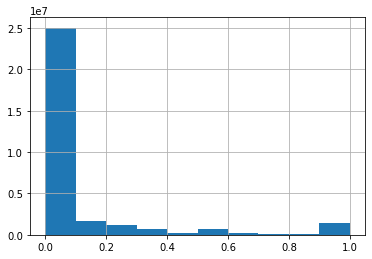

In [35]:
%%time

train['target'] = (train['sold_quantity'] / train['target_stock']).clip(0,1)
for i in range(30):
    train['target'+str(i)] = train.groupby('sku')['target'].shift(-(i+1))
    
train['target'].hist()

In [36]:
feats = ['target'+str(i) for i in range(30)]

train[ feats].head()

,target0,target1,target2,target3,target4,target5,target6,target7,target8,target9,...,target20,target21,target22,target23,target24,target25,target26,target27,target28,target29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Average sell for next 30 days
# Weight by number of days available in the next 30 days

In [37]:
feats = ['target'+str(i) for i in range(30)]
train['nonull'] = 30-train[feats].isnull().sum(1)
train['target'] = train[feats].mean(1)
train['weight'] = train['nonull'] / 30
train['weight'] = train['weight'].fillna(0)
train['nonull'].value_counts()

30    14992976
0      6927324
1       550920
2       550362
3       549817
4       549660
5       549433
6       548816
7       548200
8       547525
9       546812
10      546005
11      545799
12      545466
13      544799
14      543976
15      543208
16      542430
17      541734
18      541465
19      541067
20      540252
21      539262
22      538273
23      537386
24      536441
25      536098
26      535668
27      534241
28      533032
29      531832
Name: nonull, dtype: int64

In [38]:
train['fold'] = train['item_id'] % 5
train['fold'].value_counts()

4    7578799
2    7555281
1    7518555
0    7504564
3    7503080
Name: fold, dtype: int64

In [39]:
train = reduce_mem(train)
_ = gc.collect()

In [ ]:
params = {
    'learning_rate': 0.05,
    'max_depth': 8,
    'subsample': 0.75,
    'colsample_bytree': 0.50,
    'min_child_weight': 1,
    'random_state': 2021,
    'objective': "reg:squarederror",
    'base_score': train.target.mean(),
    'tree_method': 'hist',
    'verbosity': 1,
    'nthread': 16,
}

NROUNDS = []
MODELS = []
for fold in range(5):
    
    ind = (train.fold!=fold)&(train.target.notnull())&(train.sku.isin(test.sku)) 
    print(fold, np.sum(ind))
    dtrain = xgb.DMatrix( train.loc[ind, features], weight=train.loc[ind,'weight'], label=train.loc[ind,'target'] ) ; gc.collect()
    
    ind = (train.fold==fold)&(train.target.notnull())&(train.sku.isin(test.sku)) 
    print(fold, np.sum(ind))
    dvalid = xgb.DMatrix( train.loc[ind, features], weight=train.loc[ind,'weight'], label=train.loc[ind,'target'] ) ; gc.collect()

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=3000,#np.mean(NROUNDS),
        evals=[(dvalid,'valid')],
        early_stopping_rounds=33,
        verbose_eval=100,
        ) ; gc.collect()
    
    NROUNDS.append(model.best_iteration)
    MODELS.append(model)

0 24596119
0 6136836
[0]	valid-rmse:0.12143
[100]	valid-rmse:0.08823
[200]	valid-rmse:0.08775
[300]	valid-rmse:0.08756
[400]	valid-rmse:0.08746
[500]	valid-rmse:0.08738
[600]	valid-rmse:0.08733
[700]	valid-rmse:0.08729
[800]	valid-rmse:0.08726
[900]	valid-rmse:0.08725
[954]	valid-rmse:0.08725
1 24596769
1 6136186
[0]	valid-rmse:0.11999
[100]	valid-rmse:0.08734
[200]	valid-rmse:0.08686
[300]	valid-rmse:0.08667
[400]	valid-rmse:0.08658
[500]	valid-rmse:0.08651
[600]	valid-rmse:0.08647
[700]	valid-rmse:0.08644
[800]	valid-rmse:0.08642
[900]	valid-rmse:0.08641
[1000]	valid-rmse:0.08639
[1013]	valid-rmse:0.08639
2 24576543
2 6156412
[0]	valid-rmse:0.12156
[100]	valid-rmse:0.08803
[200]	valid-rmse:0.08754
[300]	valid-rmse:0.08737
[400]	valid-rmse:0.08728
[500]	valid-rmse:0.08722


# Use last day of train to predict for test

In [ ]:
ind = (train.icount==0)
tmp = train.loc[ind].copy()

dtest = xgb.DMatrix( tmp[features]) ; gc.collect()
tmp = tmp.reset_index(drop=True)

ypred = 1*MODELS[0].predict(dtest)
if len(MODELS)>1:
    for m in MODELS[1:]:
        ypred += m.predict(dtest)
    ypred /= len(MODELS)
    
tmp['ypred'] = np.clip(ypred,0,1)
tmp.head()

# Aggregate predictions

In [ ]:
PRED = tmp.groupby('sku')['ypred'].agg('mean').reset_index()
PRED['ypred'] = PRED['ypred'].clip(0,1)
PRED

# Load test

In [ ]:
test = pd.read_csv('../input/test_data.csv')
print( test.shape, test.sku.nunique() )
test = test.merge( PRED, on='sku', how='left' )
print( test.ypred.isnull().sum() )
test.head()

# Apply predictions + postprocessing to test

In [ ]:
sub = pd.read_csv('../input/sample_submission.csv', header=None)
for i in range(30):
    sub[i] = 1. / 30
sub[29] = 1.
print( sub.shape )

var = np.arange(0,30)
var = 1-np.log(15*var+1)
var -= var.min()
var /= var.max()
for i in range(9):
    sub[i] = test['ypred'].values * var[i]
    sub[i] = sub[i].fillna(1/30)
    sub[i] = sub[i].clip(0,1)

for i in range(9,30):
    sub[i] = sub[i].values*0.95 + sub[i-1].values*0.05
    
for i in range(1,30):
    sub[i] = (sub[i-1] + sub[i] ).clip(0,1)

for i in range(28,9,-1):
    sub[i] = sub[i].values*0.55 + sub[i+1].values*0.45
    
for i in range(29,0,-1):
    sub[i] = sub[i] - sub[i-1]
    sub[i] = sub[i].clip(0,1)

sub.loc[:,range(30)].cumsum(1).mean().plot()

In [ ]:
sub.head(40)

In [ ]:
sub.tail(40)

In [ ]:
sub.to_csv('submission-day-1-A.csv', index=False, header=None, float_format='%.4f')
# 3.9682700749312447